In [1]:
import torch
import numpy as np
import torch.optim as optim
import matplotlib as mpl

import seaborn as sns
sns.set_palette("muted")
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
def truncate_normal(input: torch.Tensor, radius):
    in_norm = input.norm(dim=1, keepdim=True)
    in_norm[in_norm > radius] = radius
    return input * in_norm / input.norm(dim=1, keepdim=True)

In [3]:
from torch import nn


class PolynomialLoss(nn.Module):
    """
    Poly-tailed margin based losses that decay as v^{-\alpha} for \alpha > 0.
    The theory here is that poly-tailed losses do not have max-margin behavior
    and thus can work with importance weighting.
    Poly-tailed losses are not defined at v=0 for v^{-\alpha}, and so there are
    several variants that are supported via the [[type]] option
    exp : f(v):= exp(-v+1) for v < 1, 1/v^\alpha otherwise
    logit: f(v):= 1/log(2)log(1+exp(-v+1)) for v < 1, 1/v^\alpha else.
    """

    allowed_types = {"logit"}

    def __init__(self, type: str, alpha: float, reduction: str = "none"):
        super().__init__()
        self.type = type
        assert type in self.allowed_types
        self.alpha = float(alpha)
        assert reduction == "none"

    def margin_fn(self, margin_vals: torch.Tensor):
        indicator = margin_vals <= 1
        inv_part = torch.pow(
            margin_vals.abs(), -1 * self.alpha
        )  # prevent exponentiating negative numbers by fractional powers
        if self.type == "logit":
            indicator = margin_vals <= 1
            inv_part = torch.pow(margin_vals.abs(),-1*self.alpha)
            logit_inner = -1 * margin_vals
            logit_part = torch.nn.functional.softplus(logit_inner)/(math.log(1+math.exp(-1)))
            scores = logit_part * indicator + inv_part * (~indicator)
            return scores

    def forward(self, logits, target):
        target_sign = 2 * target - 1
        margin_scores = (logits[:, 1] - logits[:, 0]) * target_sign
        loss_values = self.margin_fn(margin_scores)
        return loss_values

Epoch 0: loss=0.23721125721931458
Epoch 5: loss=0.07535465806722641
Epoch 10: loss=0.04647745564579964
Epoch 15: loss=0.03427884355187416
Epoch 20: loss=0.027526546269655228
Epoch 25: loss=0.02324501797556877
Epoch 30: loss=0.02029571309685707
Epoch 35: loss=0.018146201968193054
Epoch 40: loss=0.01651345007121563
Epoch 45: loss=0.015232955105602741
Epoch 50: loss=0.01420258916914463
Epoch 55: loss=0.013355689123272896
Epoch 60: loss=0.012646906077861786
Epoch 65: loss=0.012044425122439861
Epoch 70: loss=0.011525258421897888
Epoch 75: loss=0.01107250526547432
Epoch 80: loss=0.010673418641090393
Epoch 85: loss=0.010318250395357609
Epoch 90: loss=0.009999438188970089
Epoch 95: loss=0.009711035527288914
Epoch 100: loss=0.009448315016925335
Epoch 105: loss=0.009207491762936115
Epoch 110: loss=0.00898547749966383
Epoch 115: loss=0.008779739029705524
Epoch 120: loss=0.008588203229010105
Epoch 125: loss=0.008409121073782444
Epoch 130: loss=0.00824106764048338
Epoch 135: loss=0.0080828219652175

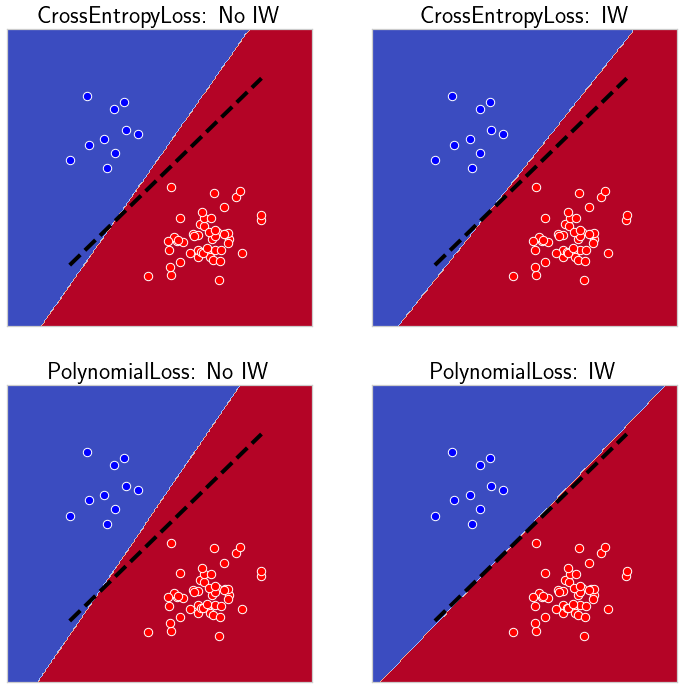

In [22]:
from itertools import product

run = 0
fig, axes = plt.subplots(figsize=(12, 12), nrows=2, ncols=2)

for loss_type, weight_type in product(["ce", "poly"], ["No IW", "IW"]):

    torch.random.manual_seed(0)

    class_one_num = 10
    class_two_num = 50
    alpha = 1.0
    num_epochs = 2000
    batch_size = class_one_num + class_two_num
    lr = 0.05
    device = "cuda"


    class_one = truncate_normal(torch.randn(class_one_num, 2), 3) + torch.tensor([[0, 5]])
    class_two = truncate_normal(torch.randn(class_two_num, 2), 3) + torch.tensor([[5, 0]])

    x_seq = torch.cat((class_one, class_two), dim=0)
    y_seq = torch.cat(
        (torch.zeros(class_one.shape[0], dtype=torch.long), torch.ones(class_two.shape[0], dtype=torch.long))
    )

    dataset = torch.utils.data.TensorDataset(x_seq, y_seq)
    dataloader = torch.utils.data.DataLoader(
        dataset=dataset, batch_size=batch_size, shuffle=True
    )

    model = torch.nn.Linear(2, 2)
    #model = torch.nn.Sequential(torch.nn.Linear(2, 100), torch.nn.ReLU(), torch.nn.Linear(100, 100), torch.nn.ReLU(), torch.nn.Linear(100, 1))
    
    model = model.to(device)

    if loss_type == "ce":
        loss_fn = torch.nn.CrossEntropyLoss(reduction="none")
    else:
        loss_fn = PolynomialLoss(type="logit", alpha=alpha)

    optimizer = optim.SGD(model.parameters(), lr=lr)

    w_seq = []
    for i in range(num_epochs):
        for xs, ys in dataloader:
            xs = xs.to(device)
            ys = ys.to(device)

            optimizer.zero_grad()

            logits = model(xs)

            if weight_type == "IW":
                loss_ratio = (ys == 1) + (ys == 0) * class_two_num / float(class_one_num)
            else:
                loss_ratio = torch.ones(ys.shape[0])
            loss_ratio = loss_ratio.to(device)
            
            loss = torch.mean(loss_fn(logits, ys) * loss_ratio)

            loss.backward()

            optimizer.step()
        if i % 5 == 0:
            print(f"Epoch {i}: loss={loss.item()}")
            #w_seq.append(
            #    [(n, p.detach().cpu().numpy().copy()) for n, p in model.named_parameters()]
            #)

    print(w_seq)

    model = model.cpu()

    xrng = np.linspace(min(x_seq[:, 0]), max(x_seq[:, 0]), num=50)


    def ymap(xseq, weight, bias):
        print(weight)
        print(bias)
        return (xseq * weight[0] + bias) / (-1 * weight[1])

    ax = axes.flatten()[run]
    
    xlim = ylim = (-4, 10)
    ax.set(ylim=ylim, xlim=xlim)
    
    g1 = np.linspace(*xlim, num=200)
    g2 = np.linspace(*ylim, num=200)
    
    x1, x2 = np.meshgrid(g1, g2)
    X = np.stack([x1, x2], axis=-1).reshape(-1, 2)

    y = model(torch.as_tensor(X).float()).detach().cpu().numpy()
    y = np.argmax(y, axis=-1)
    y = 2 * y - 1.  # convert to [-1, 1]
    y_grid = y.reshape(len(g1), len(g2))
    
    lim = max(abs(np.min(y)), abs(np.max(y)))
    
    cs = ax.contourf(x1, x2, y_grid, cmap="coolwarm", vmin=-lim, vmax=lim, levels=2)
    #cb = fig.colorbar(cs, ax=ax)

    # TODO: Plot margin in gold
    
    ax.scatter(class_one[:, 0], class_one[:, 1], color="blue", edgecolors="w", s=70)
    ax.scatter(class_two[:, 0], class_two[:, 1], color="red", edgecolors="w", s=70)
#    cmap = plt.cm.get_cmap("winter")
#     for widx in range(len(w_seq)):
#         frac_val = float(widx) / float(len(w_seq))
#         print(frac_val)
#         yvals = ymap(xrng, w_seq[widx][0][1][0], w_seq[widx][1][1])
#         ax.plot(xrng, yvals, color=cmap(frac_val))
    ax.plot(xrng, xrng, color="black", linewidth=4, linestyle="--")
    ax.set(xticklabels=[], yticklabels=[])
    ax.set(title=f"{type(loss_fn).__name__}: {weight_type}")
    
    ax.grid(False)
    
#     fig.savefig(
#         ""
#         + loss_type
#         + "-"
#         + weight_type
#         + "-"
#         + str(class_one_num)
#         + "-"
#         + str(class_two_num)
#         + ".pdf"
#     )
    
    run += 1

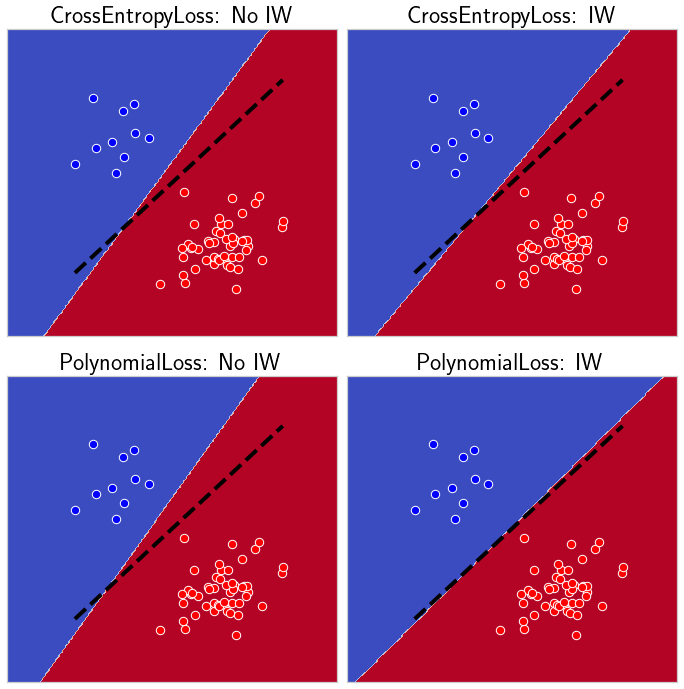

In [34]:
fig.subplots_adjust(wspace=0.03, hspace=0.13)
fig

In [35]:
fig.savefig("margin.pdf", bbox_inches="tight")